<a href="https://www.kaggle.com/code/garimachaubey310/variational-autoencoder-on-mnist?scriptVersionId=233031165" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [3]:
#Hyperparameters

batch_size=128
latent_dim=20
epochs=10
learning_rate=1e-3
device=torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [4]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [5]:
train_dataset=datasets.MNIST(root='./kaggle/working', train=True, transform=transform, download=True)
train_loader=DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 42.9MB/s]


Extracting ./kaggle/working/MNIST/raw/train-images-idx3-ubyte.gz to ./kaggle/working/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.68MB/s]


Extracting ./kaggle/working/MNIST/raw/train-labels-idx1-ubyte.gz to ./kaggle/working/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.4MB/s]


Extracting ./kaggle/working/MNIST/raw/t10k-images-idx3-ubyte.gz to ./kaggle/working/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.10MB/s]

Extracting ./kaggle/working/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./kaggle/working/MNIST/raw



In [6]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        #encoder
        self.fc1=nn.Linear(28*28, 400)
        self.fc_mu=nn.Linear(400, latent_dim)
        self.fc_logvar=nn.Linear(400, latent_dim)

        #Decoder
        self.fc3=nn.Linear(latent_dim, 400)
        self.fc4=nn.Linear(400, 28*28)

    def encode(self,x):
        h1=F.relu(self.fc1(x))
        mu=self.fc_mu(h1)
        log_var=self.fc_logvar(h1)
        return mu,log_var

    def reparametrize(self, mu, log_var):
        std=torch.exp(0.5*log_var)
        eps=torch.rand_like(std)
        return mu+eps*std

    def decode(self,z):
        h3=F.relu(self.fc3(z))
        return torch.tanh(self.fc4(h3))

    def forward(self,x):
        x=x.view(-1,28*28)
        mu, log_var=self.encode(x)
        z=self.reparametrize(mu, log_var)
        recon=self.decode(z)
        return recon, mu, log_var



In [7]:
#Loss = Reconstructin+KL

import torch.nn.functional as F

def vae_loss(recon_x, x, mu, log_var):
    BCE = F.mse_loss(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    return BCE + KLD

In [8]:
model=VAE().to(device)
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
#Training

losses=[]
for epoch in range(epochs):
    total_loss=0
    model.train()
    for batch, _ in train_loader:
        batch=batch.to(device)
        recon, mu, log_var=model(batch)
        loss=vae_loss(recon, batch, mu, log_var)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()

    avg_loss=total_loss/len(train_loader.dataset)
    losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

Epoch [1/10], Loss: 103.0985
Epoch [2/10], Loss: 63.1403
Epoch [3/10], Loss: 57.8301
Epoch [4/10], Loss: 54.9443
Epoch [5/10], Loss: 53.0776
Epoch [6/10], Loss: 51.8933
Epoch [7/10], Loss: 50.8000
Epoch [8/10], Loss: 50.0523
Epoch [9/10], Loss: 49.4360
Epoch [10/10], Loss: 48.9111


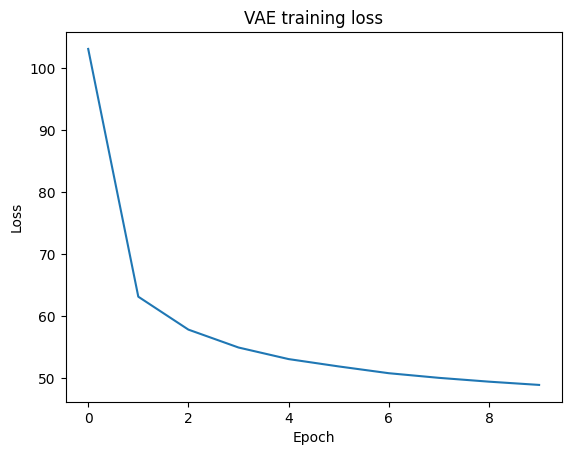

In [10]:
plt.plot(losses)
plt.title("VAE training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [11]:
#Visualize reconstruction

model.eval()
test_batch, _=next(iter(train_loader))
test_batch=test_batch.to(device)
with torch.no_grad():
    recon_batch, _, _ =model(test_batch)
recon_batch=recon_batch.view(-1,1,28,28).cpu()

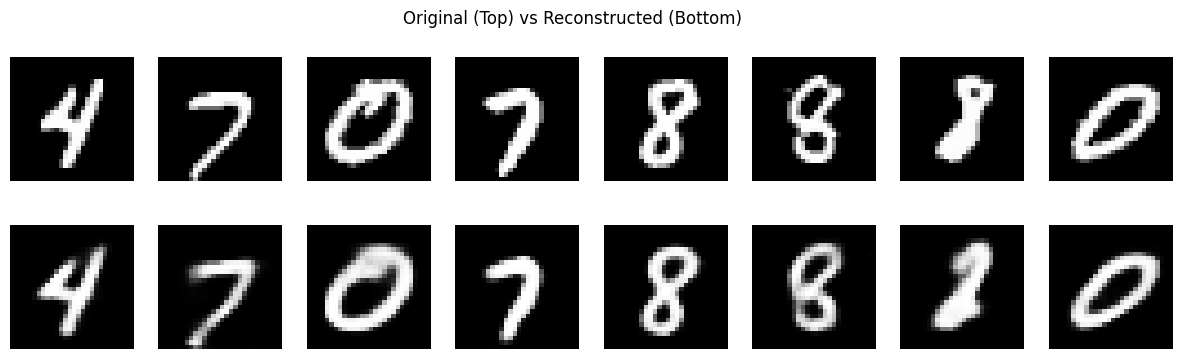

In [12]:
# Show original vs reconstructed
n = 8
plt.figure(figsize=(15, 4))
for i in range(n):
    # Original
    plt.subplot(2, n, i + 1)
    plt.imshow(test_batch[i][0].cpu(), cmap='gray')
    plt.axis('off')

    # Reconstructed
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon_batch[i][0], cmap='gray')
    plt.axis('off')
plt.suptitle("Original (Top) vs Reconstructed (Bottom)")
plt.show()

In [13]:
#Training
epochs=20
losses=[]
for epoch in range(epochs):
    total_loss=0
    model.train()
    for batch, _ in train_loader:
        batch=batch.to(device)
        recon, mu, log_var=model(batch)
        loss=vae_loss(recon, batch, mu, log_var)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()

    avg_loss=total_loss/len(train_loader.dataset)
    losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

Epoch [1/20], Loss: 48.4637
Epoch [2/20], Loss: 48.1027
Epoch [3/20], Loss: 47.8116
Epoch [4/20], Loss: 47.3805
Epoch [5/20], Loss: 47.0897
Epoch [6/20], Loss: 46.9203
Epoch [7/20], Loss: 46.6927
Epoch [8/20], Loss: 46.4483
Epoch [9/20], Loss: 46.2705
Epoch [10/20], Loss: 46.0417
Epoch [11/20], Loss: 45.8517
Epoch [12/20], Loss: 45.7409
Epoch [13/20], Loss: 45.5949
Epoch [14/20], Loss: 45.5019
Epoch [15/20], Loss: 45.2871
Epoch [16/20], Loss: 45.1304
Epoch [17/20], Loss: 45.0086
Epoch [18/20], Loss: 44.9524
Epoch [19/20], Loss: 44.8109
Epoch [20/20], Loss: 44.6657


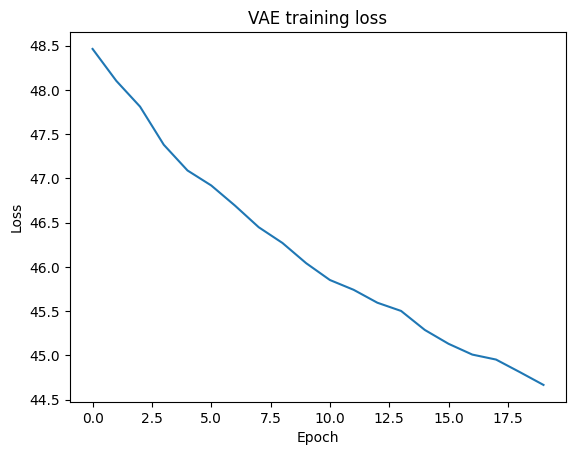

In [14]:
plt.plot(losses)
plt.title("VAE training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [15]:
#Visualize reconstruction

model.eval()
test_batch, _=next(iter(train_loader))
test_batch=test_batch.to(device)
with torch.no_grad():
    recon_batch, _, _ =model(test_batch)
recon_batch=recon_batch.view(-1,1,28,28).cpu()

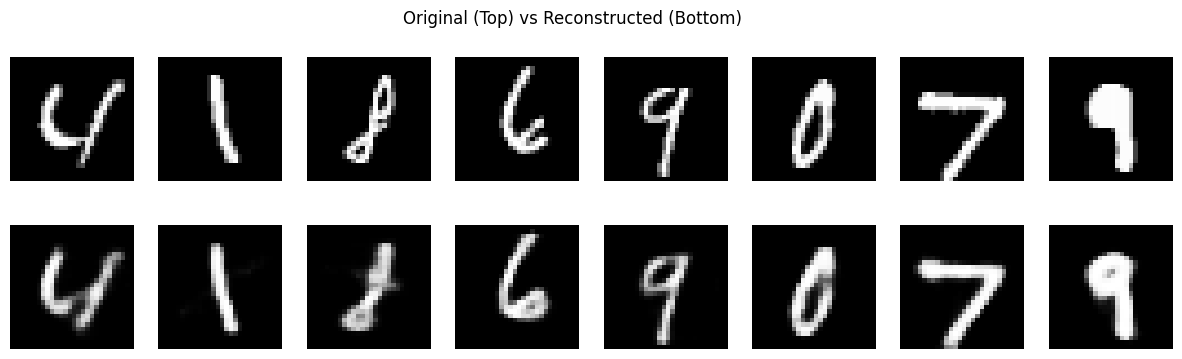

In [16]:
# Show original vs reconstructed
n = 8
plt.figure(figsize=(15, 4))
for i in range(n):
    # Original
    plt.subplot(2, n, i + 1)
    plt.imshow(test_batch[i][0].cpu(), cmap='gray')
    plt.axis('off')

    # Reconstructed
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon_batch[i][0], cmap='gray')
    plt.axis('off')
plt.suptitle("Original (Top) vs Reconstructed (Bottom)")
plt.show()